## Analysis of results

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from scipy.stats import linregress
import textwrap
from matplotlib.lines import Line2D

### Citylearn KPIs

In [90]:
all_results = []
n_buildings = [2,4,8]
for n in n_buildings:
    results = {}
    models = ['mpc','sac','ppo']
    for model in models:
        kpis = {
            # 'all_time_peak_average': 'Average peak cost.',
            'carbon_emissions_total': 'Rolling sum of carbon emissions.', 
            'cost_total': 'Rolling sum of electricity monetary cost.',
            'electricity_consumption_total': 'Rolling sum of positive electricity consumption.',
            'daily_one_minus_load_factor_average': 'A measure of load variability / peakiness (daily average).', 
            'daily_peak_average': 'Average daily peak cost.',
            # 'monthly_one_minus_load_factor_average': 'A measure of load variability / peakiness (monthly average).',
            'ramping_average': 'Average rolling sum of absolute difference in net electric consumption between consecutive time steps',
            # 'zero_net_energy': 'Rolling sum of net electricity consumption'
        }
        result = pd.read_csv(f'results/results_{model}_2022_centralized/{n}_buildings/performance_kpis.csv')
        result = result[result['cost_function'].isin(kpis.keys())].reset_index(drop=True)
        result = result[result['level']=='district'].reset_index(drop=True)
        result = result.rename(columns={'value': model})
        results[model] = result
    agg_results = results['mpc'][['cost_function', 'mpc']].merge(results['ppo'][['cost_function', 'ppo']], on='cost_function').merge(results['sac'][['cost_function', 'sac']], on='cost_function')
    agg_results['best'] = agg_results[['mpc', 'ppo', 'sac']].idxmin(axis=1)
    agg_results['n_buildings'] = n
    agg_results = agg_results.round(2)
    agg_results = agg_results[['n_buildings', 'cost_function', 'mpc', 'ppo', 'sac', 'best']]
    all_results.append(agg_results)
all_results = pd.concat(all_results, ignore_index=True)

In [91]:
# Convert to long format for seaborn
df_long = all_results.melt(
    id_vars=['n_buildings', 'cost_function'],
    value_vars=['mpc', 'ppo', 'sac'],
    var_name='method',
    value_name='value'
)

# color transparency 
ALPHA = 0.6

# order of the cost functions
ordered_costs = [
    "cost_total",
    "electricity_consumption_total",
    "carbon_emissions_total",
    "daily_peak_average",
    "ramping_average",
    "daily_one_minus_load_factor_average",
]

### Line Plot of Method Performance Across Cost Functions and Building Counts

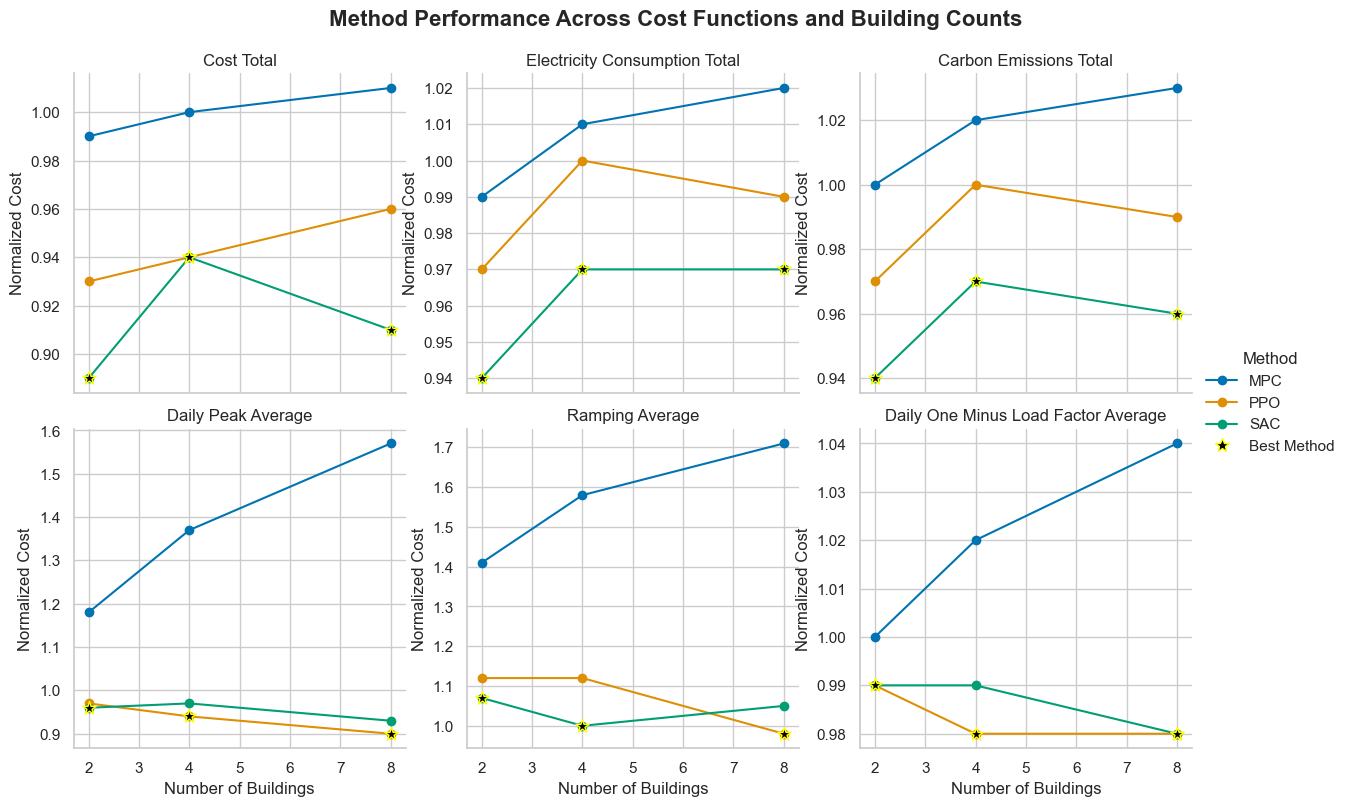

In [92]:
# Identify the best method per group (min value)
df_long['is_best'] = df_long.groupby(['n_buildings', 'cost_function'], observed=False)['value'].transform('min') == df_long['value']

# Set up colorblind-friendly palette
palette = sns.color_palette("colorblind")

# specify the order of cost functions 
df_long['cost_function'] = pd.Categorical(
    df_long['cost_function'],
    categories=ordered_costs,
    ordered=True
).dropna()

# Plot
sns.set(style="whitegrid")
g = sns.FacetGrid(
    df_long, col="cost_function",
    col_order = ordered_costs,
    col_wrap=3, height=4, sharey=False # normalize y-limits
)

# Add lines with markers and highlight best points
def plot_func(data, **kwargs):
    for method in ['mpc', 'ppo', 'sac']:
        subset = data[data['method'] == method]
        plt.plot(subset['n_buildings'], subset['value'],
                 marker='o', label=method.upper(),
                 color=palette[['mpc', 'ppo', 'sac'].index(method)])
        
        # Highlight best points
        best_points = subset[subset['is_best']]
        plt.scatter(best_points['n_buildings'], best_points['value'],
                    color='black', edgecolor='yellow', s=100, zorder=10, marker='*')

g.map_dataframe(plot_func)

# Improve axis labels
for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel("Normalized Cost")
    ax.set_xlabel("Number of Buildings")

# Improve facet titles
for ax in g.axes.flat:
    title = ax.get_title().replace("cost_function = ", "").replace("_", " ").title()
    ax.set_title(title)

# Add legend and title
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Method Performance Across Cost Functions and Building Counts", fontsize=16, fontweight='bold')

# Custom "Best Method" star legend entry
star_best = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                          markersize=10, markeredgecolor='yellow', label='Best Method')

# Get existing handles and labels from the first axis
handles, labels = g.axes[0].get_legend_handles_labels()

# Append the star marker
handles.append(star_best)
labels.append('Best Method')

# Add the updated legend
g.add_legend(handles=handles, labels=labels, title='Method')
plt.show()

### Bar Plot (Grouped by Cost Function)

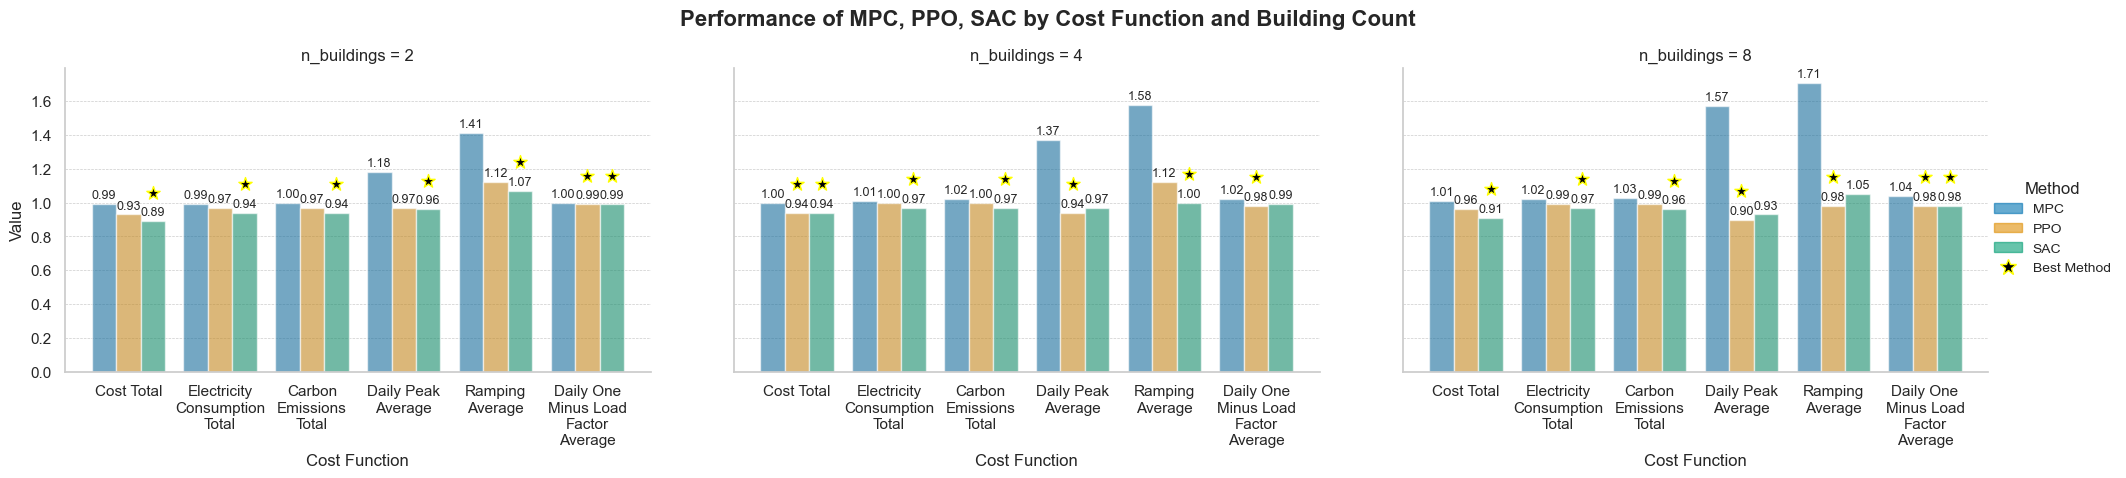

In [93]:
# Mark best
df_long["is_best"] = df_long.groupby(
    ["cost_function", "n_buildings"], observed=True
)["value"].transform("min") == df_long["value"]

# Reorder cost_function by average performance
avg_cost = df_long.groupby("cost_function", observed=True)["value"].mean().sort_values()
df_long["cost_function"] = pd.Categorical(df_long["cost_function"], 
                                          categories=ordered_costs, 
                                          ordered=True)

# Set color palette
palette = sns.color_palette("colorblind")
method_order = ["mpc", "ppo", "sac"]
color_map = dict(zip(method_order, palette))

# Plot with col-wise layout (horizontal stacking)
sns.set(style="whitegrid")
g = sns.catplot(
    data=df_long,
    x="cost_function", y="value", hue="method",
    col="n_buildings", kind="bar",
    hue_order=method_order,
    palette=color_map,
    height=4.2, aspect=1.8,
    sharey=True,
    width=0.8,
    alpha=ALPHA
)
g.set_axis_labels("Cost Function", "Value")

# Adjust spacing
g.fig.subplots_adjust(right=0.85, hspace=0.3, top=0.88)
g.fig.suptitle("Performance of MPC, PPO, SAC by Cost Function and Building Count", fontsize=16, x=0.45, y=1.02, fontweight='bold')

# Clean up ticks, titles, annotate values and stars
for ax, n in zip(g.axes.flat, [2, 4, 8]):
    # Set clearer subplot titles
    ax.set_title(f"n_buildings = {n}", fontsize=12)

    # Format x-axis labels
    xticks = ax.get_xticks()
    xticklabels = ['\n'.join(textwrap.wrap(tick.get_text().replace('_', ' ').title(), width=11)) for tick in ax.get_xticklabels()]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=0, ha='center')

    # Add grid lines
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5)

    # Annotate value labels and stars
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            x = bar.get_x() + bar.get_width() / 2
            ax.text(x, 
                    height + 0.015, 
                    f"{height:.2f}", 
                    ha='center', 
                    va='bottom', 
                    fontsize=9)

    for i, tick in enumerate(ax.get_xticks()):
        cost_func = ordered_costs[i]
        for method in method_order:
            subset = df_long[
                (df_long["cost_function"] == cost_func) &
                (df_long["n_buildings"] == n) &
                (df_long["method"] == method)
            ]
            if not subset.empty and subset.iloc[0]["is_best"]:
                bar = ax.containers[method_order.index(method)][i]
                ax.scatter(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 0.17,
                    marker='*', s=100, zorder=10,
                    facecolor='black', edgecolor='yellow'
                )

# Add custom legend on the right
method_handles = [
    mpatches.Patch(color=color_map[m], label=m.upper(), alpha=ALPHA) for m in method_order
]
star_legend = mlines.Line2D(
    [], [], marker='*', linestyle='None',
    markersize=12,
    markerfacecolor='black',
    markeredgecolor='yellow',
    label='Best Method'
)

g._legend.remove()
legend = g.fig.legend(
    handles=method_handles + [star_legend],
    title="Method",
    loc='center left',
    bbox_to_anchor=(0.85, 0.5),
    borderaxespad=0,
    fontsize='small',
    title_fontsize='medium'
)
legend.get_frame().set_visible(False)
plt.savefig("plots/Performance of MPC, PPO, SAC by Cost Function and Building Count")
plt.show()

### Heatmap of Best Method Counts

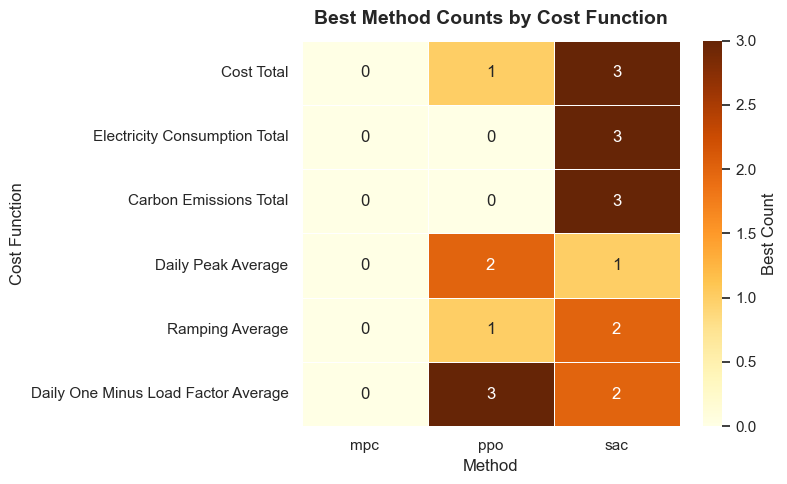

In [94]:
# Count how often each method is best for each cost function
best_counts = df_long[df_long['is_best']].groupby(
    ['cost_function', 'method'], observed=True
).size().unstack(fill_value=0)

# Reindex to include all methods
best_counts = best_counts.reindex(columns=["mpc", "ppo", "sac"], fill_value=0)

# Sort by total wins
best_counts['total'] = best_counts.sum(axis=1)
best_counts = best_counts.sort_values('total', ascending=False).drop(columns='total')
best_counts = best_counts.reindex(ordered_costs)
best_counts.index = [
    label.replace('_', ' ').title() for label in best_counts.index
]

# Plot
plt.figure(figsize=(8, 5))
sns.heatmap(
    best_counts,
    annot=True, fmt="d",
    cmap="YlOrBr",
    linewidths=0.5,
    cbar_kws={'label': 'Best Count'}
)
plt.title("Best Method Counts by Cost Function", fontsize=14, pad=12, fontweight='bold')
plt.ylabel("Cost Function", fontsize=12)
plt.xlabel("Method", fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Best method per cost function and building count

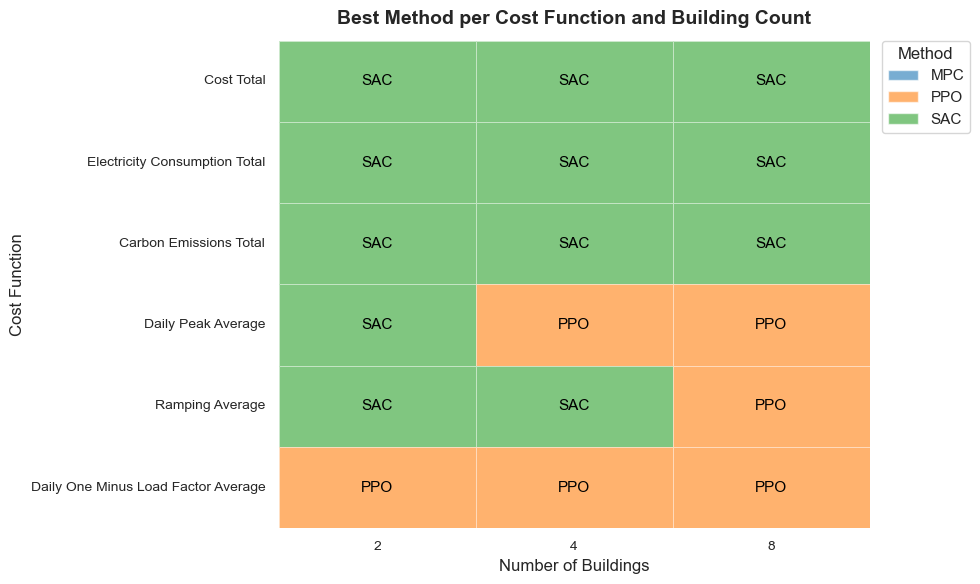

In [95]:
# Color palette
method_to_code = {"mpc": 0, "ppo": 1, "sac": 2}
code_to_method = {v: k for k, v in method_to_code.items()}
method_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green

# Data prep
best_by_building = all_results.pivot(index="cost_function", columns="n_buildings", values="best")
best_by_building = best_by_building.reindex(ordered_costs)
best_by_building.index = [
    label.replace('_', ' ').title() for label in best_by_building.index
]
method_matrix = best_by_building.map(lambda x: method_to_code.get(x, -1))  # -1 for missing

# Plot
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    method_matrix,
    cmap=ListedColormap(["#ff7f0e", "#1f77b4", "#2ca02c"]),
    annot=best_by_building.map(str.upper),  # show 'SAC', 'PPO', etc.
    fmt='',
    linewidths=0.5,
    linecolor='white',
    cbar=False,
    alpha=ALPHA,
    annot_kws={"fontsize": 11}
)
ax.grid(False)

# Improve annotation contrast
for text in ax.texts:
    method = text.get_text().lower()
    text.set_color("black")

# Axis labels and title
plt.title("Best Method per Cost Function and Building Count", fontsize=14, pad=12, fontweight='bold')
plt.xlabel("Number of Buildings", fontsize=12)
plt.ylabel("Cost Function", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Legend
legend_elements = [
    Patch(facecolor=color, label=label.upper(), alpha=ALPHA)
    for label, color in zip(method_to_code.keys(), method_colors)
]
plt.legend(
    handles=legend_elements,
    title="Method",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0
)

plt.tight_layout()
plt.show()


### Radar chart for each method

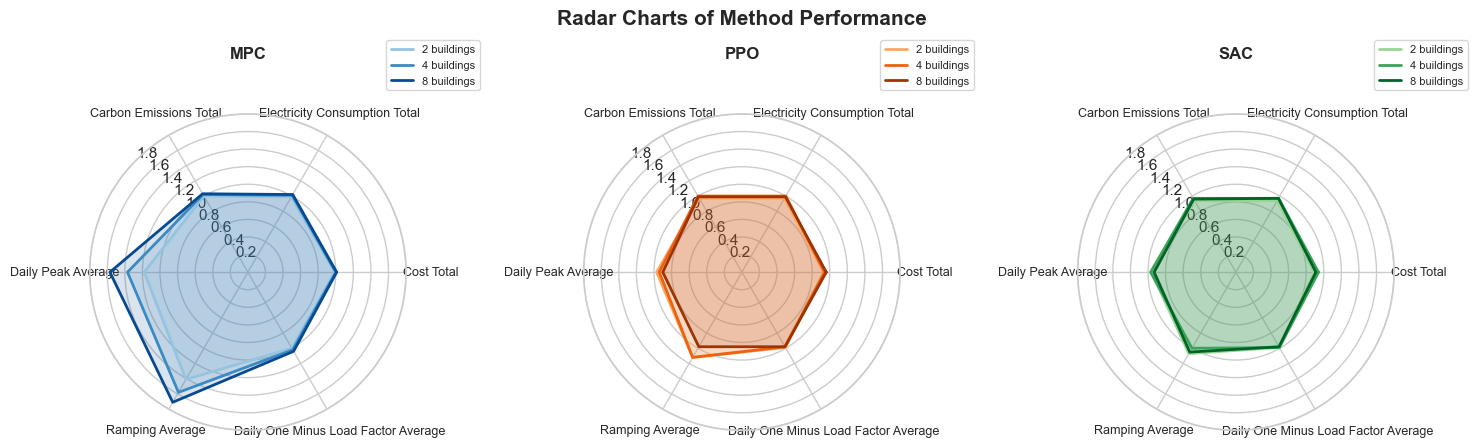

In [96]:
# Pivot the data
radar_data = df_long.pivot_table(
    index=["method", "n_buildings"],
    columns="cost_function",
    values="value",
    observed=True
)

# Reorder the columns by desired cost function order
radar_data = radar_data[ordered_costs]

# Sort the index
radar_data = radar_data.sort_index()

colors = {
    'mpc': mpl.colormaps['Blues'],
    'ppo': mpl.colormaps['Oranges'],
    'sac': mpl.colormaps['Greens']
}

building_sizes = [2, 4, 8]
intensity = np.linspace(0.4, 0.9, len(building_sizes))  # Lighter to darker

# Assume `radar_data` is already set: MultiIndex (method, n_buildings) x cost_function
cost_functions = list(radar_data.columns)
n_costs = len(cost_functions)
angles = np.linspace(0, 2 * np.pi, n_costs, endpoint=False).tolist() + [0]

# Plotting function
def plot_radar(df, method, ax):
    for i, n in enumerate(building_sizes):
        values = df.loc[(method, n)].tolist()
        values += values[:1]
        color = colors[method](intensity[i])
        ax.plot(angles, values, label=f'{n} buildings', color=color, linewidth=2)
        ax.fill(angles, values, color=color, alpha=0.15)
    
    # Axis aesthetics
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(
        [c.replace('_', ' ').title() for c in cost_functions],
        fontsize=9,
        ha='center',
        zorder=100
    )
    ax.tick_params(pad=5)
    ax.set_rlabel_position(135)
    ax.set_ylim(0, 1.8)
    ax.set_title(f"{method.upper()}", y=1.15, fontsize=12, fontweight='bold')

# Plot setup
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(15, 5))
for i, method in enumerate(['mpc', 'ppo', 'sac']):
    plot_radar(radar_data, method, axs[i])
    axs[i].legend(loc='upper right', bbox_to_anchor=(1.25, 1.25), fontsize=8)

plt.suptitle("Radar Charts of Method Performance", fontsize=15, y=0.93, fontweight='bold')
plt.tight_layout()
plt.show()

### Scalability

In [97]:
# Melt the wide-format table to long-format
df_long = all_results.melt(
    id_vars=["n_buildings", "cost_function"],
    value_vars=["mpc", "ppo", "sac"],
    var_name="method",
    value_name="value"
)

# Compute slopes: scalability = slope of value vs. n_buildings
scalability_scores = []

for (method, cost), group in df_long.groupby(["method", "cost_function"]):
    slope, intercept, r_value, p_value, std_err = linregress(group["n_buildings"], group["value"])
    scalability_scores.append({
        "method": method,
        "cost_function": cost,
        "slope": slope,
        "r2": r_value**2,
        "p_value": p_value
    })

scalability_df = pd.DataFrame(scalability_scores)

# compute normalized slopes for comparison between functions 
scalability_df['normalized_slope'] = scalability_df.groupby('cost_function')['slope'].transform(
    lambda x: (x - x.mean()) / x.std()
)

print(scalability_df)

   method                        cost_function     slope        r2  \
0     mpc               carbon_emissions_total  0.004643  0.862245   
1     mpc                           cost_total  0.003214  0.964286   
2     mpc  daily_one_minus_load_factor_average  0.006429  0.964286   
3     mpc                   daily_peak_average  0.062857  0.969576   
4     mpc        electricity_consumption_total  0.004643  0.862245   
5     mpc                      ramping_average  0.047500  0.930412   
6     ppo               carbon_emissions_total  0.002500  0.250000   
7     ppo                           cost_total  0.005000  1.000000   
8     ppo  daily_one_minus_load_factor_average -0.001429  0.571429   
9     ppo                   daily_peak_average -0.011429  0.988417   
10    ppo        electricity_consumption_total  0.002500  0.250000   
11    ppo                      ramping_average -0.025000  0.892857   
12    sac               carbon_emissions_total  0.002500  0.250000   
13    sac           

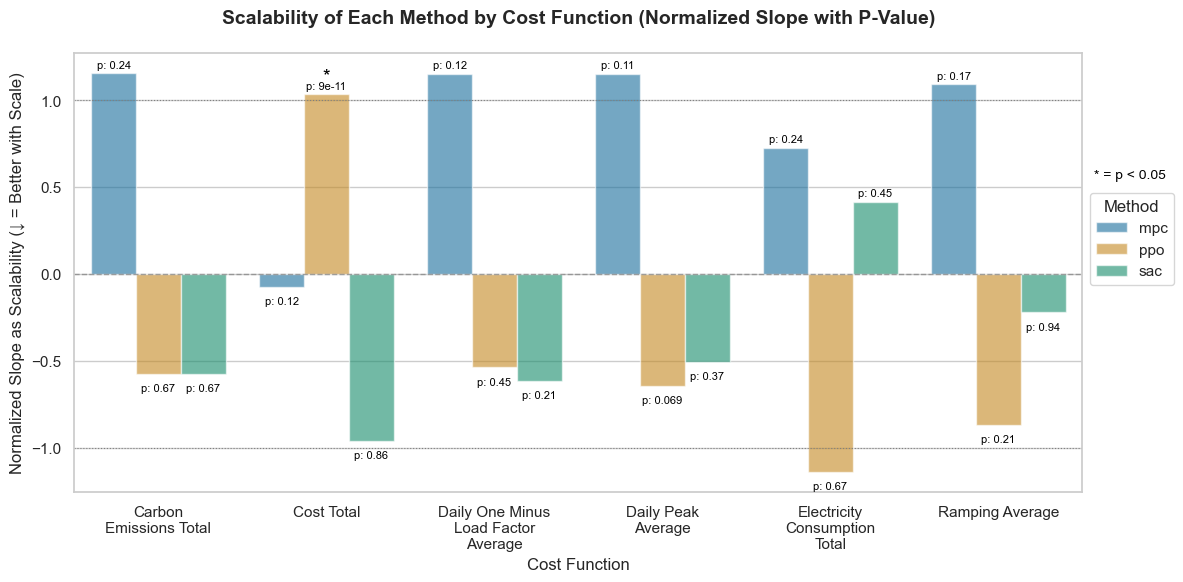

In [98]:
# Set up figure
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=scalability_df,
    x="cost_function",
    y="normalized_slope",
    hue="method",
    palette="colorblind",
    err_kws={'linewidth': 1.5},
    capsize=0.1,
    alpha=ALPHA
)

# Draw reference lines
ax.axhline(0, color='gray', linewidth=1, linestyle='--', alpha=0.7)
ax.axhline(1, color='gray', linestyle=':', linewidth=0.8)
ax.axhline(-1, color='gray', linestyle=':', linewidth=0.8)

# Collect unique cost functions in the same order as in the plot
cost_functions = scalability_df["cost_function"].unique()

# Annotate bars
bar_width = 0.8 / 3  # Split total bar group width across 3 methods
method_offsets = {'mpc': -bar_width, 'ppo': 0, 'sac': bar_width}

for index, row in scalability_df.iterrows():
    cost_idx = list(cost_functions).index(row["cost_function"])
    xpos = cost_idx + method_offsets[row["method"]]
    ypos = row["normalized_slope"]

    # Annotate p-value
    ax.text(
        xpos, ypos + 0.03 if ypos >= 0 else ypos - 0.10,
        f"p: {row['p_value']:.2g}", fontsize=8, ha="center", color="black"
    )

    # Star if significant
    if row["p_value"] < 0.05:
        ax.text(
            xpos, ypos + 0.05 if ypos >= 0 else ypos - 0.2,
            "*", ha="center", va="bottom", color="black", fontsize=14
        )

# Improve x-axis labels: wrap + center
wrapped_labels = ['\n'.join(textwrap.wrap(label.replace('_', ' ').title(), width=15)) for label in cost_functions]
ax.set_xticks(range(len(cost_functions)))
ax.set_xticklabels(wrapped_labels, ha='center')

# Titles and labels
ax.set_ylabel("Normalized Slope as Scalability (↓ = Better with Scale)")
ax.set_xlabel("Cost Function")
ax.set_title("Scalability of Each Method by Cost Function (Normalized Slope with P-Value)", fontsize=14, y=1.05, fontweight='bold')

# Legend and asterisk note
ax.legend(title="Method", bbox_to_anchor=(1, 0.7))
plt.text(len(cost_functions)-0.43, 0.55, "* = p < 0.05", fontsize=10, color='black')

plt.tight_layout()
plt.show()

### Computational metrics

In [99]:
computational_metrics = pd.read_csv('results/computational_metrics.csv')
df_long = computational_metrics.melt(
    id_vars=['n_buildings', 'cost_function', 'best'],
    value_vars=['mpc', 'ppo', 'sac'],
    var_name='method',
    value_name='value'
)

### Line Plot (Scalability Trend)

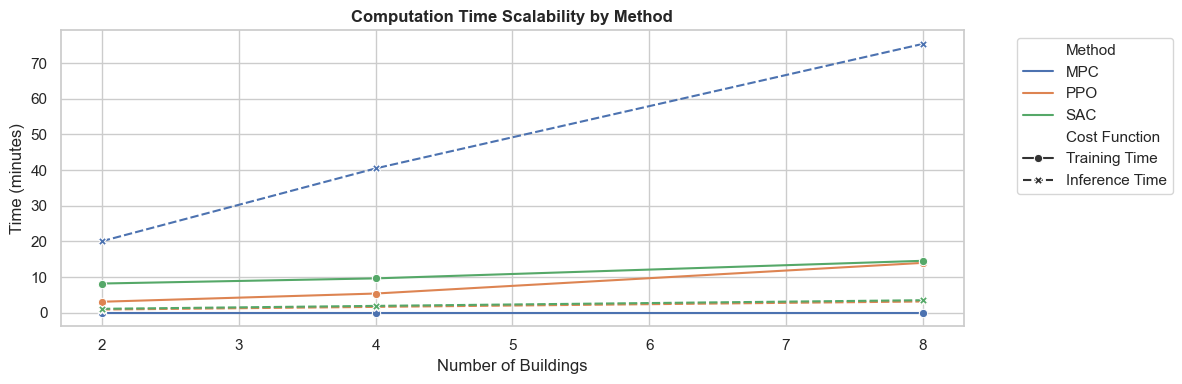

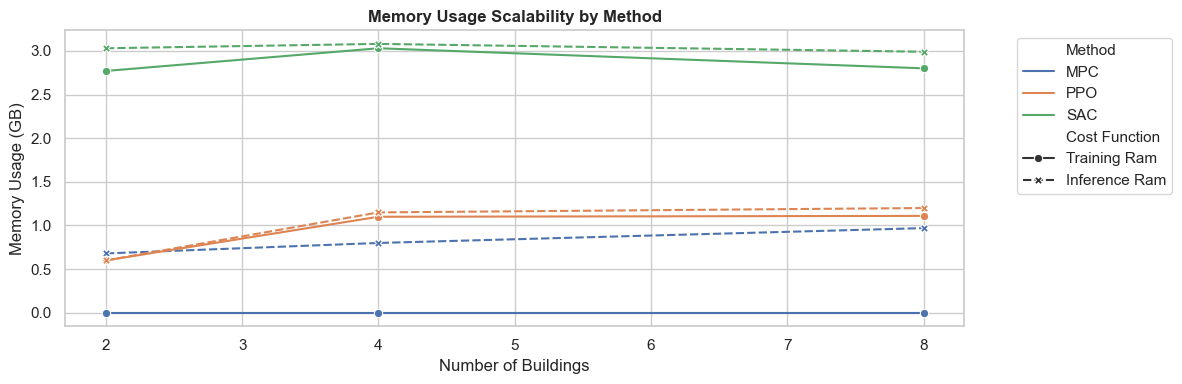

In [100]:
# Apply label mapping
df_long_formatted = df_long.copy()
df_long_formatted['Method'] = df_long_formatted['method'].map({'mpc': 'MPC', 'ppo': 'PPO', 'sac': 'SAC'})
df_long_formatted['Cost Function'] = df_long_formatted['cost_function'].map({
    'training_time': 'Training Time',
    'inference_time': 'Inference Time',
    'training_ram': 'Training Ram',
    'inference_ram': 'Inference Ram'
})

# Split data
df_time = df_long_formatted[df_long_formatted["Cost Function"].str.contains("Time")]
df_ram = df_long_formatted[df_long_formatted["Cost Function"].str.contains("Ram")]

# Plot time
plt.figure(figsize=(12, 4))
sns.lineplot(data=df_time, x='n_buildings', y='value', hue='Method', style='Cost Function', markers=True)
plt.title("Computation Time Scalability by Method", fontweight='bold')
plt.ylabel("Time (minutes)")
plt.xlabel("Number of Buildings")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot RAM
plt.figure(figsize=(12, 4))
sns.lineplot(data=df_ram, x='n_buildings', y='value', hue='Method', style='Cost Function', markers=True)
plt.title("Memory Usage Scalability by Method", fontweight='bold')
plt.ylabel("Memory Usage (GB)")
plt.xlabel("Number of Buildings")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Grouped Bar Plot

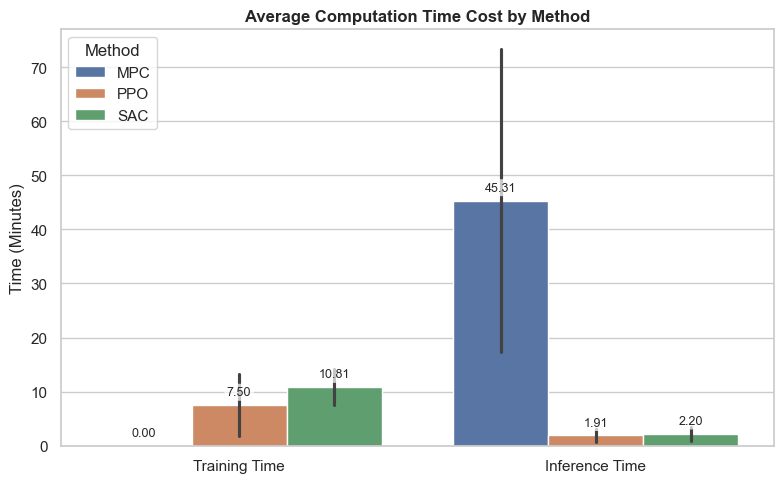

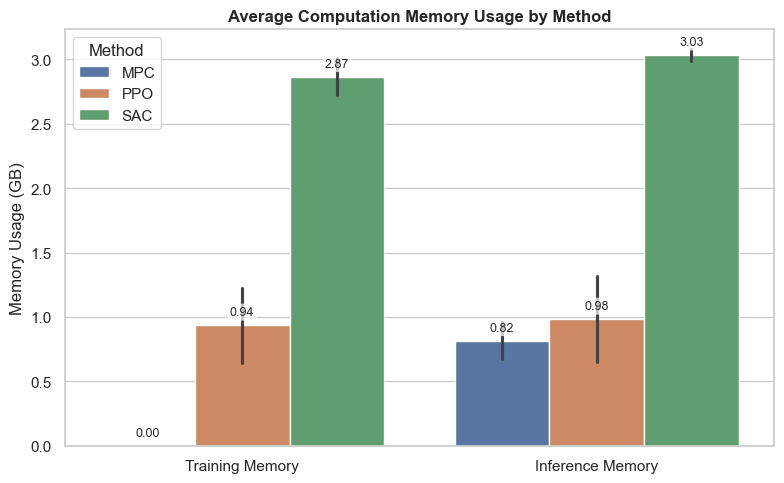

In [101]:
# Subset for time-related cost functions
df_time = df_bar[df_bar['Cost Function'].isin(['Training Time', 'Inference Time'])]

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_time, x='Cost Function', y='value', hue='Method', errorbar='sd')

# Annotate bar heights
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if not np.isnan(height):
            ax.annotate(
                f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7, edgecolor='none')
            )

plt.title("Average Computation Time Cost by Method", fontweight='bold')
plt.ylabel("Time (Minutes)")
plt.xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(title="Method", loc='upper left') 
plt.show()

# Subset for memory-related cost functions
df_mem = df_bar[df_bar['Cost Function'].isin(['Training Memory', 'Inference Memory'])]

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_mem, x='Cost Function', y='value', hue='Method', errorbar='sd')

# Annotate bar heights
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if not np.isnan(height):
            ax.annotate(
                f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7, edgecolor='none')
            )


plt.title("Average Computation Memory Usage by Method", fontweight='bold')
plt.ylabel("Memory Usage (GB)")
plt.xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(title="Method", loc='upper left') 
plt.show()


### Heatmap of Best Method

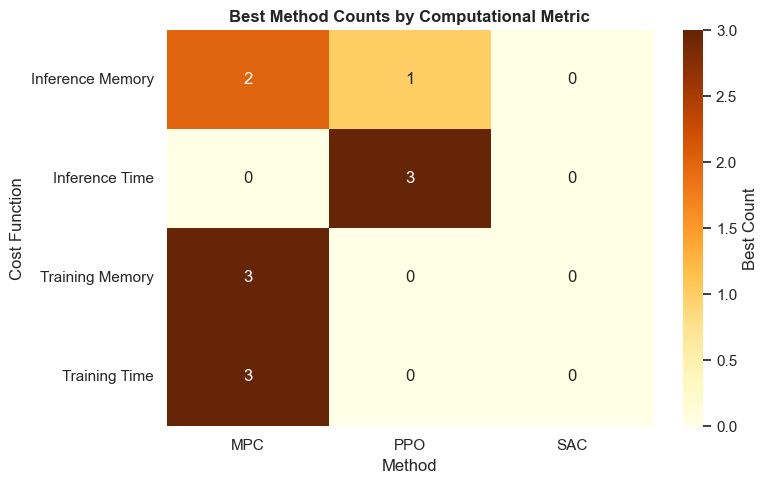

In [102]:
df = computational_metrics.copy()

# Ensure all methods are included (even if count is 0)
methods = ['mpc', 'ppo', 'sac']
df['best'] = pd.Categorical(df['best'], categories=methods)

# Create pivot table and fill missing values with 0
pivot = pd.crosstab(df['cost_function'], df['best']).reindex(columns=methods, fill_value=0)

# Clean up cost function labels
label_map = {
    'training_time': 'Training Time',
    'inference_time': 'Inference Time',
    'training_ram': 'Training Memory',
    'inference_ram': 'Inference Memory'
}
pivot.index = pivot.index.to_series().map(label_map)
pivot.columns = ['MPC', 'PPO', 'SAC']  # Capitalize method names

# Plot
plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, cmap="YlOrBr", fmt="d", cbar_kws={'label': 'Best Count'})
plt.title("Best Method Counts by Computational Metric", fontweight='bold')
plt.ylabel("Cost Function")
plt.xlabel("Method")
plt.tight_layout()
plt.show()


### Scalability Slopes

In [103]:
results = []
for (method, cost), group in df_long.groupby(['method', 'cost_function']):
    slope, intercept, r_value, p_value, std_err = linregress(group['n_buildings'], group['value'])
    results.append({
        'method': method,
        'cost_function': cost,
        'slope': slope,
        'r2': r_value**2,
        'p_value': p_value
    })

scalability_slopes_df = pd.DataFrame(results)

# compute normalized slopes for comparison between functions 
scalability_slopes_df['normalized_slope'] = scalability_slopes_df.groupby('cost_function')['slope'].transform(
    lambda x: (x - x.mean()) / x.std()
)
print(scalability_slopes_df)

   method   cost_function     slope        r2   p_value  normalized_slope
0     mpc   inference_ram  0.047500  0.991758  0.057875          0.113035
1     mpc  inference_time  9.150000  0.998422  0.025294          1.154697
2     mpc    training_ram  0.000000  0.000000  1.000000         -0.531551
3     mpc   training_time  0.000000  0.000000  1.000000         -1.050282
4     ppo   inference_ram  0.087500  0.644737  0.406520          0.938680
5     ppo  inference_time  0.376786  0.999997  0.001045         -0.579749
6     ppo    training_ram  0.073214  0.588355  0.443455          1.153520
7     ppo   training_time  1.864286  0.982689  0.084004          0.940690
8     sac   inference_ram -0.008929  0.365925  0.586412         -1.051715
9     sac  inference_time  0.401071  0.999941  0.004909         -0.574948
10    sac    training_ram -0.003929  0.007119  0.946221         -0.621969
11    sac   training_time  1.086071  0.986550  0.073997          0.109592


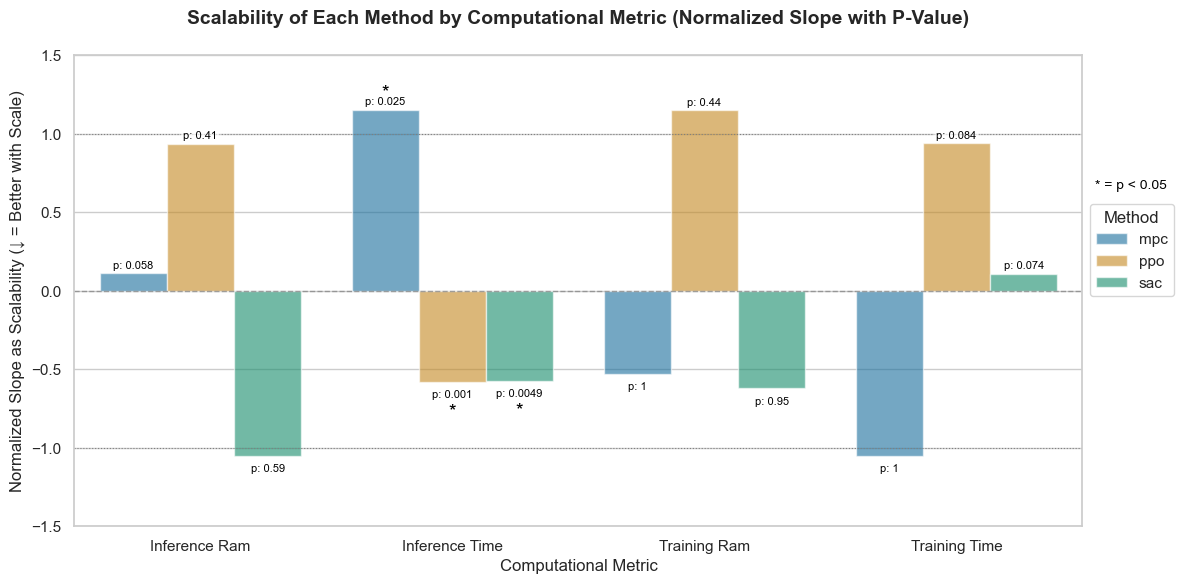

In [104]:
# Set up figure
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=scalability_slopes_df,
    x="cost_function",
    y="normalized_slope",
    hue="method",
    palette="colorblind",
    err_kws={'linewidth': 1.5},
    capsize=0.1,
    alpha=ALPHA
)

# Draw reference lines
ax.axhline(0, color='gray', linewidth=1, linestyle='--', alpha=0.7)
ax.axhline(1, color='gray', linestyle=':', linewidth=0.8)
ax.axhline(-1, color='gray', linestyle=':', linewidth=0.8)

# Collect unique cost functions in the same order as in the plot
cost_functions = scalability_slopes_df["cost_function"].unique()

# Annotate bars
bar_width = 0.8 / 3  # Split total bar group width across 3 methods
method_offsets = {'mpc': -bar_width, 'ppo': 0, 'sac': bar_width}

for index, row in scalability_slopes_df.iterrows():
    cost_idx = list(cost_functions).index(row["cost_function"])
    xpos = cost_idx + method_offsets[row["method"]]
    ypos = row["normalized_slope"]

    # Annotate p-value
    ax.text(
        xpos, ypos + 0.03 if ypos >= 0 else ypos - 0.10,
        f"p: {row['p_value']:.2g}", fontsize=8, ha="center", color="black",
        bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7, edgecolor='none')
    )

    # Star if significant
    if row["p_value"] < 0.05:
        ax.text(
            xpos, ypos + 0.05 if ypos >= 0 else ypos - 0.25,
            "*", ha="center", va="bottom", color="black", fontsize=14
        )

# Improve x-axis labels: wrap + center
wrapped_labels = ['\n'.join(textwrap.wrap(label.replace('_', ' ').title(), width=15)) for label in cost_functions]
ax.set_xticks(range(len(cost_functions)))
ax.set_xticklabels(wrapped_labels, ha='center')

# Titles and labels
ax.set_ylabel("Normalized Slope as Scalability (↓ = Better with Scale)")
ax.set_xlabel("Computational Metric")
ax.set_title("Scalability of Each Method by Computational Metric (Normalized Slope with P-Value)", fontsize=14, y=1.05, fontweight='bold')

# Legend and asterisk note
ax.legend(title="Method", bbox_to_anchor=(1, 0.7))
plt.text(len(cost_functions)-0.45, 0.65, "* = p < 0.05", fontsize=10, color='black')
plt.ylim(-1.5, 1.5)
plt.tight_layout()
plt.show()